In [1]:
#math and linear algebra stuff
import numpy as np

#Math and linear algebra stuff
import scipy.stats as scs

#plots
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15.0, 15.0)
#mpl.rc('text', usetex = True)
import matplotlib.pyplot as plt
%matplotlib inline

# Understanding the Kullback Liebler divergence

## Some notation
Let's talk about a set of sample vectors $x_i$ where $x_i \in \mathbb{R}^n , i=0,1,\dots n-1$, such that each $x_i$ is an output of a random process, that can be modeled using a probability density function: 
$$
    P_{\theta}(x) = P(x|\theta)
$$

We can also define the empirical data distribution, that sums to one, using:
$$
    P_{D}(x) = \frac{1}{N} \sum_{i=1}^{N} \delta(x-x_i)
$$

## Quantity of information

### Information theory framework
In the framework of information theory, a signal of interest can be modeled as a message produced by a transmitter, enventually modified by the channel, that should be retrieved by the receiver.
The intrinsic complexity of the message, or the quantity of information it contains can be modeled using shannon entropy, defined itself as the expectation of the self information for symbols coming from a given class of message.

### Self information
Self information $I$ of a random event $\omega$ with probability $P(\omega)$ is defined as

$$
    I(\omega) = log\left(\frac{1}{P(\omega)}\right) = -log(P(\omega))
$$

We generally use the logarithm in base 2 so that self information can be defined in bits, and so do the entropy.
Let's list some interesting properties of this metric:
  - as $I$ is a monotically increasing function of $\frac{1}{P(\omega)}$, the realisation of the event that have a low probability gives us a large quantity of information.
  - An event that is not random, ie for wich $P(\omega)=1$ gives no informations.
  - The simultanneous occurence of two independent events $\omega_a$ and $\omega_b$ with respective probability $P(\omega_a)$ and $P(\omega_b)$ bring us a total quantity of infomation equal to the sum of the information of the two events, due to the use of the logarithm.


### Entropy
Shannon entropy $H(x)$, as said earlier is defined as $H(x)=E[I(X)] = E[-log(P(x))]$ which reads in the discrete case:
$$
    H(x) = - \sum_{i=1}^{N} P(x_i)log(P(x_i))
$$

It is interesting to notice that $H(x)$ can be interpreted as the entopy rate of a data source or the average number of bits per symbol needed to encode a message whith a known symbol probability density function.

This concept can obviously be extended to blocks or structured blocks of data instead of symbols.

#### A small numerical illustration
Let's say that we have a random bit generator, that can be tuned to generate the value $1$ with a probability $P_1$ varying from $0$ to $1$, the probability that the random bit generator output $0$ is given by $P_0 = 1-P_1$. This is a classic Bernoulli scheme.
The entropy of this binary source is then
$$
    P_1 log_2(P_1) + P_0 log_2(P_0) =  P_1 log_2(P_1) +  (1-P_1) log_2(1-P_1)
$$

Let see what does the entropy of this random bit generator, along the value of $P_1$

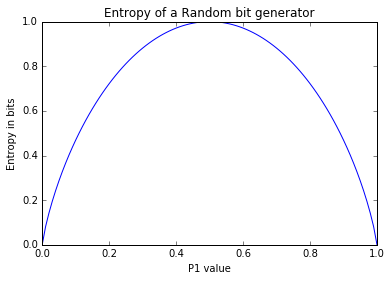

In [2]:
#P1 values:
P1=np.linspace(0,1,101)

#Handle numerical instability of log in 0
def SafeLog2( v ):
    r=v.copy()
    r[v!=0]=np.log2(v[v!=0])
    return r

#Entropy of a Bernouilli distribution with probability p
def BernoulliEntropy( p ):
    return -( p*SafeLog2(p)+(1-p)*SafeLog2(1-p) )

#plot entropy functions of P1
plt.plot(P1,BernoulliEntropy(P1))

#Fancy stuff
plt.title('Entropy of a Random bit generator')
plt.xlabel('P1 value')
plt.ylabel('Entropy in bits')

In [3]:
#In some cases latter, we will need to compute the entropy of a dataset
def GetEntropyFromQuantizedData( v, num_bins=100 ):
    """
        We assume that v is a vector
    """
    
    #Data is divided in num_bins equally spaced bins, then the histogram is returned
    hist,edges = np.histogram(v,bins=num_bins)
    
    #get the empirical distribution, use floating point division
    p=np.double(hist)/np.sum(hist)

    #scipy entropy simply compute -sum(p * log(p))
    return p, scs.entropy(p)

## Relative quantity of information

### Introduction
It is very common in engineering to try to find dependency between data, so that we can exploit some knowledges or intuitions over relationships between them. In some cases, we can measure the validity of this model by measuring the relative quantity of informations given by a random variable when the outcome of some other random process in known, using the following tools:

### Entropy of random Markov process
A common way to give probabilistic interpretation of signals, or messages, is to account for the probability of occurence of a symbol given the 0, 1, 2, ..., p previous symbols in the signal.
This model is known as the order-p Markov source, let's fist see how entropy is computed for a order-1 markov process:
$$
    H(S) = -\sum_i p_i \sum_j p(j|i)log(p(i|j)
$$
Where $j$ is the current symbol, and $i$ is the preceding symbol.
For a second order Markov process, we have:
$$
    H(S) = -\sum_i p_i \sum_j p(j|i) \sum_k p(k|i,j) log(p(k|i,j))
$$

#### A small numerical illustration
Let's say that we have a 1 dimensional signal from $\mathbb{Z}^N$, and we want to model the occurence of every new symbol in this signal as a first order random markov process.
This model allows us to study the entropy of the signal in another framework, let's see how entropy values compares in the basic and markov models.

Sum of empirical distribution is  1.0
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
te

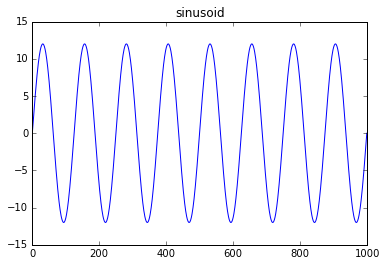

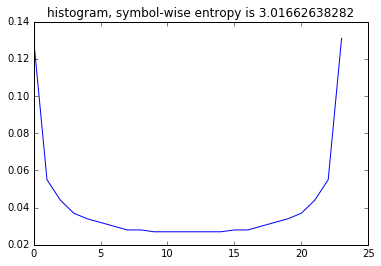

In [6]:
#First: generate a sinusoid like signal, of amplitude -5 +5
halfAmplitude = 12
amplitude = 2*halfAmplitude
s=halfAmplitude*np.sin(np.linspace(0,8*2*np.pi,1000))

#Plot signal of interest
plt.figure()
plt.plot(s)
plt.title('sinusoid')

#compute histogram and symbol-wise entropy of this signal
p,entropy=GetEntropyFromQuantizedData(s,amplitude)

#plot the histogram of values in the signal
plt.figure()
plt.plot(p)
plt.title('histogram, symbol-wise entropy is '+str(entropy))
print "Sum of empirical distribution is ",np.sum(p)


#Now use the first order markov model, by first computing the markov chain matrix
hist,edges = np.histogram(s,bins=amplitude)

#Define markov matrix
markov=np.zeros((hist.size,hist.size))

#previous element
for i in range(hist.size):
    #index in s where you can find previous element
    if( i < hist.size-1 ):
        idx = (s>=edges[i]) * (s<edges[i])
    else: #last range has both sides included, see numpy doc
        idx = (s>=edges[i]) * (s<=edges[i])
    
    #Now we should add one
        
        



### Conditional Entropy
The concept of entropy also extends to conditional probability of events, in this case, $H(x|y)$ can be interpreted as the amount of information needed to describe the outcome of a random process y, given the value of the random process x and reads:

\begin{align}
    H(x|y)  &= \sum_{j=1}^{K} p(y_j) H(x|y=y_j) \\
            &= \sum_{j=1}^{K} p(y_j) \sum_{i=1}^{N} -p(x_i|y_j) log(p(x_i|y_j)) \\
            &= -\sum_{j=1}^{K} \sum_{i=1}^{N} p(x_i,y_j) log(p(x_i|y_j)) \\
            &= -\sum_{j\in J,i\in I} p(x_i,y_j) log(p(x_i|y_j)) \\
            &= -\sum_{j\in J,i\in I} p(x_i,y_j) log\left(\frac{p(x_i,y_j)}{p(y_j)}\right) \\
            &=  \sum_{j\in J,i\in I} p(x_i,y_j) log\left(\frac{p(y_j)}{p(x_i,y_j)}\right)
\end{align}

### Chain rule
If a random process output depends itself on two random variables $x$ and $y$, its entropy can be considered as the joint entropy $H(x,y)$, which in the binary case, is the minimum number of bits needed to describe one output.
If we know in advance the value of $y$, we have gained $H(y)$ bits of information, so we now only need $H(x,y)-H(y)$ to describe the output, that is somehow more deterministic.

This is called the chaine rule and reads:
$$
    H(x|y) = H(x,y)-H(y)
$$

The proof is quite straightforward:

\begin{align}
    H(x|y)  &= \sum_{j\in J,i\in I} p(x_i,y_j) log\left(\frac{p(y_j)}{p(x_i,y_j)}\right) \\
            &= -\sum_{j\in J,i\in I} p(x_i,y_j) log(p(x_i,y_j)) + \sum_{j\in J,i\in I} p(x_i,y_j) log(p(y_j)) \\
            &= H(x,y) + \sum_{j\in J,i\in I} p(x_i,y_j) log(p(y_j)) \text{which is a marginal distribution}\\
            &= H(x,y) + \sum_{j\in J,i\in I} p(y_j) log(p(y_j)) \\
            &= H(x,y)-H(y)
\end{align}


### Bayes' rule
The famous Bayes theorem links conditional probability of two random variables, for instance $x$ and $y$:
$$
    p(x|y) = \frac{p(y|x)p(x)}{p(y)}
$$
Following the chain rule, and the fact that $H(x,y)=H(y,x)$ we can easly extends the Bayes rule for conditional entropy:
\begin{align}
    H(x|y)  &= H(x,y)-H(y) \\
            &= H(y,x)-H(y) \\
            &= H(y|x)+H(x)-H(y)
\end{align}

### Mutual information
This quantity gives an indication about the dependence between two random variables, it is more general than correlation coefficient, and not limited to real valued data.
The mutual information between two random variables $x$ and $y$ reads
$$
    I(x,y) = \sum_{i=1}^{N} \sum_{j=1}^{K} p(x_i,y_j) log\left( \frac{p(x_i,y_j)}{p(x_i)p(y_j)} \right)
$$

We can link this expression to conditional entropy:
\begin{align}
    I(x,y)  &= \sum_{i=1}^{N} \sum_{j=1}^{K} p(x_i,y_j) log\left( \frac{p(x_i,y_j)}{p(x_i)p(y_j)} \right) \\
            &= \sum_{j\in J,i\in I} p(x_i,y_j) log\left( \frac{p(x_i,y_j)}{p(x_i)p(y_j)} \right)

\end{align}

In [52]:
groundTruthEntropyRange=(vectorizedGroundTruthImage.min(),vectorizedGroundTruthImage.max())
groundThruthHistogram, groundTruthBins = np.histogram(vectorizedGroundTruthImage,bins=100,range=groundTruthEntropyRange )
groundTruthEntropy.fill( scipy.stats.entropy(pk=groundThruthHistogram,base=2) )

NameError: name 'vectorizedGroundTruthImage' is not defined